In [ ]:
!pip3 install scikit-learn
!pip3 install torch
!pip3 install torchinfo


In [ ]:
!pip3 install google-colab

In [ ]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import OneSidedSelection, InstanceHardnessThreshold, NearMiss, ClusterCentroids
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns


In [ ]:
'''CONFIG FOR LOCAL / CLOUD RUNNING'''
running_local = 'content' not in os.getcwd()
if running_local:
    path = ''
else:
    from google.colab import drive
    drive.mount('/content/drive')
    path = 'drive/MyDrive/StructuralBioinformatics/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# RUN ONLY TO REBUILD DATASET CSV
#dfs = []
#for filename in os.listdir('features_ring'):
#    if filename[-4:] == '.tsv':
#        dfs.append(pd.read_csv('features_ring/' + filename, sep='\t'))
#df = pd.concat(dfs)
#df

In [ ]:
# don't need to execute - only to export df for training in cloud
#df.to_csv('contact_df.csv')

In [ ]:
df = pd.read_csv(path + 'data/contact_df.csv')
df.dropna(inplace=True)

# Define ground truth values
y = df['Interaction'].astype('category')
y_oneHot = pd.get_dummies(y)
cat_names = list(y.cat.categories)
y


0               VDW
1             HBOND
2             HBOND
3         PIPISTACK
4             HBOND
            ...    
454188          VDW
454189        HBOND
454190          VDW
454191        HBOND
454192        HBOND
Name: Interaction, Length: 454193, dtype: category
Categories (6, object): ['HBOND', 'IONIC', 'PICATION', 'PIPISTACK', 'SSBOND', 'VDW']

In [ ]:
# Define training features
X = df[['s_rsa', 's_up', 's_down', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5',
        't_rsa', 't_up', 't_down', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5']]

#is this working?
X = X.fillna({col: X[col].mode()[0] for col in X.columns})

print("Scaling data...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Scaling data...


In [ ]:
# Create the test and train split (from ORIGINAL data)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_oneHot, test_size=0.1, random_state=123, stratify=y_oneHot)

# TO FIX: WE NEED A VALIDATION SET THAT IS NOT AFFECTED BY THE PREPROCESSING!
# For now, I'm using the test set with a constraint on the indexes in the training function to use as a validation set, but we need a better solution.

n_splits=10
kf = KFold(n_splits=n_splits, shuffle=True)

In [ ]:
# Preprocessing TRAIN DATA ONLY

#X_scaled = pd.DataFrame(X_scaled, columns=X.columns) #why are we casting it to a DF?
X_train = np.array(X_train) #undersampler and oversampler expects arrays
y_train = np.array(y_train) #undersampler and oversampler expects arrays


if True:
  print("Undersampling data...")
  undersample = InstanceHardnessThreshold(estimator=AdaBoostClassifier(),sampling_strategy={0:3*22703,5:2*21318})
  X_train, y_train = undersample.fit_resample(X_train, y_train)

  print("Oversampling data...")
  oversample = SMOTE(sampling_strategy={1:16189,2:11349,3:16444,4:11997})
  X_train, y_train = oversample.fit_resample(X_train, y_train)

Undersampling data...
Oversampling data...


In [ ]:
np.sum(count)

454193

In [ ]:
count

array([297636,   8002,    545,   9218,    781, 138011])

In [ ]:
lc = np.log10(count)
normlc = lc / np.sum(lc)
np.round(normlc*100000)

array([22703., 16189., 11349., 16444., 11997., 21318.])

In [ ]:
# Recast into Dataframes (to fix: conventionally np.arrays are to be fed to the network, not DataFrames)

X_train = pd.DataFrame(X_train, columns=X.columns)
y_train = pd.DataFrame(y_train)

X_test = pd.DataFrame(X_test, columns=X.columns)
y_test = pd.DataFrame(y_test)

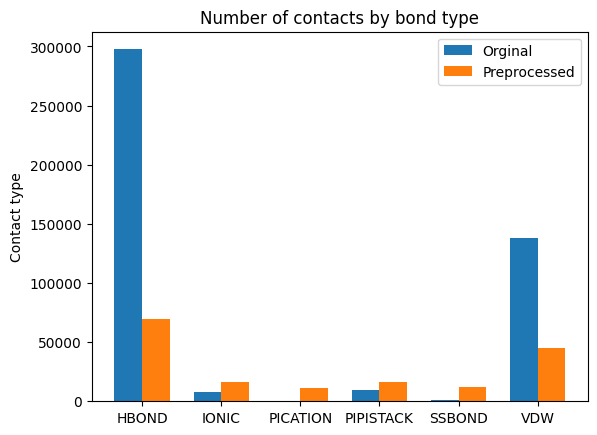

In [ ]:
y_arg = np.argmax(y_oneHot.values, axis=1)
y_arg_processed = np.argmax(y_train.values, axis=1)
_, count = np.unique(y_arg, return_counts=True)
class_count = dict(zip(cat_names, count))
_, count_processed = np.unique(y_arg_processed, return_counts=True)
class_count_processed = dict(zip(cat_names, count_processed))

fig, ax = plt.subplots()
x = np.arange(len(cat_names))  # label locations
width = 0.35  # width of the bars
rects1 = ax.bar(x - width/2, count, width, label='Orginal')
rects2 = ax.bar(x + width/2, count_processed, width, label='Preprocessed')

# Add labels, title, and legend
ax.set_ylabel('Examples')
ax.set_ylabel('Contact type')
ax.set_title('Number of contacts by bond type')
ax.set_xticks(x)
ax.set_xticklabels(cat_names)
ax.legend()

plt.show()

In [ ]:
class ContactNet(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_layers_dim=[], dropout_prob=0.2):
        super().__init__()
        self.layers = nn.ModuleList()
        if len(hidden_layers_dim) == 0:
            self.layers = self.layers.append(nn.Linear(input_dim, num_classes))
        else:
            for layer_idx in range(len(hidden_layers_dim)):
                if layer_idx == 0:  # first layer, from input to hidden
                    self.layers = self.layers.append(nn.Linear(input_dim, hidden_layers_dim[layer_idx]))
                else:  # hidden layers, depending on the input
                    self.layers = self.layers.append(nn.Linear(hidden_layers_dim[layer_idx-1], hidden_layers_dim[layer_idx]))
                self.layers.append(nn.Dropout(p=dropout_prob)) # add dropout layer after each hidden layer
            self.layers = self.layers.append(nn.Linear(hidden_layers_dim[-1], 1))  # final output layer
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=.1)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x)
        if x.dtype != torch.float32:
            x = x.float()
        if len(self.layers) == 1:
            return self.layers[0](x)
        else:
            for layer in self.layers[:-1]:
                x = F.relu(layer(x))
        return F.log_softmax(x, dim=1)#self.layers[-1](x)

input_size = X.shape[1]  # The number of input features
num_classes = y_oneHot.shape[1] # The number of output classes

model = ContactNet(input_size, num_classes, [64, 128, 256, 256])

# Criterion and optimizer
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss ()
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

summary(model)

Layer (type:depth-idx)                   Param #
ContactNet                               --
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       1,344
│    └─Dropout: 2-2                      --
│    └─Linear: 2-3                       8,320
│    └─Dropout: 2-4                      --
│    └─Linear: 2-5                       33,024
│    └─Dropout: 2-6                      --
│    └─Linear: 2-7                       65,792
│    └─Dropout: 2-8                      --
│    └─Linear: 2-9                       514
Total params: 108,994
Trainable params: 108,994
Non-trainable params: 0

In [ ]:
class EarlyStopping:
    def __init__(self, tolerance, min_delta):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if abs(validation_loss - train_loss) > self.min_delta:
            self.counter += 1
            if self.counter >= self.tolerance:
                self.early_stop = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# TO DO: Cast all dataframes to np.arrays or torch.tensors

def train(model, optimizer, num_epochs, l2_lambda=0.01):
    early_stopping = EarlyStopping(tolerance=10, min_delta=0.01) # slow to learn, so it has to be VERY tolerant

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    current_fold_counter=0

    for train_index, val_index in kf.split(X_train): # temporarily discarding kfold to test on test set and have a baseline. Remember to reindent all under this

      current_fold_counter += 1

      early_stopping.early_stop = False
      early_stopping.counter = 0

      X_train_fold = X_train.values #Recasted to a pd.DataFrame but ideally we should use np.ndarray everywhere
      y_train_fold = y_train.values


      # Here I'm just trying to see if maybe I can reuse the entire test set with validation indexes from X_train without going out of bound.
      # I don't even know if this makes sense but that's the only thing that I could think as of right now
      # val_index_adjusted = val_index[val_index < len(X_test)]
      # X_val_fold = X_test.values[val_index_adjusted]
      # y_val_fold = y_test.values[val_index_adjusted]
      X_val_fold = X_train.values[val_index]
      y_val_fold = y_train.values[val_index]

      for epoch in range(num_epochs):
          out = model(torch.tensor(X_train_fold))
          y_train_fold_labels = np.argmax(y_train_fold, axis=1)
          loss = criterion(out, torch.tensor(y_train_fold_labels).long())

          ############## L2 Regularization ################
          parameters = torch.tensor([], device=device)

          for param in model.parameters():
              flattened_param = param.view(-1)
              parameters = torch.cat((parameters, flattened_param), dim=0)

          l2_norm = torch.linalg.norm(parameters, 2).pow(2)
          loss = loss + l2_norm * l2_lambda

          #################################################

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          with torch.no_grad():

            val_outputs = model(torch.tensor(X_val_fold))
            y_val_fold_labels = np.argmax(y_val_fold, axis=1)
            val_loss = criterion(val_outputs, torch.tensor(y_val_fold_labels).long())
            _, val_preds = torch.max(val_outputs, 1)
            val_accuracy = accuracy_score(y_val_fold_labels, val_preds) # are we sure this is correct?
            train_accuracy = accuracy_score(y_train_fold_labels, torch.argmax(out, 1))

            ############# Testing other ways ###############

            #train_outputs = model(torch.tensor(X_train_fold))
            #y_train_fold_labels = np.argmax(y_train_fold, axis=1)
            #train_loss = criterion(train_outputs, torch.tensor(y_train_fold_labels).long())
            #_, train_preds = torch.max(train_outputs, 1)
            #train_accuracy = accuracy_score(y_train_fold_labels, train_preds)

            #val_outputs = model(torch.tensor(X_val_fold))
            #y_val_fold_labels = np.argmax(y_val_fold, axis=1)
            #val_loss = criterion(val_outputs, torch.tensor(y_val_fold_labels).long())
            #_, val_preds = torch.max(val_outputs, 1)
            #val_accuracy = accuracy_score(y_val_fold_labels, val_preds)

            ################################################





          print(f'Fold: {current_fold_counter}/{n_splits} - Epoch {epoch+1}/{num_epochs}')
          print(f'Train Loss: {loss.item()} - Validation Loss: {val_loss.item()} - Train Accuracy: {train_accuracy} - Validation Accuracy: {val_accuracy}')

          train_losses.append(loss.item())
          val_losses.append(val_loss.item())
          train_accuracies.append(train_accuracy)
          val_accuracies.append(val_accuracy)


            # Check for early stopping
            #early_stopping(loss.item(), val_loss.item())
            #if early_stopping.early_stop:
            #    print('Early stopping triggered...')
            #    break

        #if early_stopping.early_stop:
        #    break

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
class OvAClassifier:
    def __init__(self, base_model, num_classes):
        self.models = [copy.deepcopy(base_model) for _ in range(num_classes)]

    def fit(self, X, y, num_epochs):
      X = torch.tensor(X)
      y = torch.tensor(y)
      for i, model in enumerate(self.models):
          # Adjust labels so that the class of interest is 1 and all others are 0
          y_arg = torch.argmax(y, dim=1)
          y_adjusted = (y_arg == i).float()
          #y_adjusted = (torch.tensor(y) == i).float()
          optimizer = torch.optim.Adam(model.parameters())
          criterion = nn.BCEWithLogitsLoss()

          for epoch in range(num_epochs):
              optimizer.zero_grad()
              outputs = model(X)
              loss = criterion(outputs, y_arg)
              loss.backward()
              optimizer.step()

    def predict(self, X):
        with torch.no_grad():
            outputs = [model(X) for model in self.models]
        # Choose the class with the highest output
        return torch.argmax(torch.stack(outputs), dim=0)


In [ ]:
model(torch.tensor(X_train.values)).shape

torch.Size([170533, 256])

In [ ]:
ova = OvAClassifier(model, num_classes)

In [ ]:
(torch.tensor(y_train.values)==1).float().shape

torch.Size([170533, 6])

In [ ]:
ova.fit(X_train.values, y_train.values, 10)

ValueError: ignored

In [ ]:
EPOCHS = 20
l2_lambda = 0

train_loss, val_loss, train_accuracy, val_accuracy = train(model, optimizer, num_epochs=EPOCHS, l2_lambda=l2_lambda)

Fold: 1/10 - Epoch 1/20
Train Loss: 5.567069053649902 - Validation Loss: 5.540438175201416 - Train Accuracy: 0.00032286848099185195 - Validation Accuracy: 0.006046375110067508
Fold: 1/10 - Epoch 2/20
Train Loss: 5.5404229164123535 - Validation Loss: 5.507997035980225 - Train Accuracy: 0.006304740883368164 - Validation Accuracy: 0.03105371294393895
Fold: 1/10 - Epoch 3/20
Train Loss: 5.508038520812988 - Validation Loss: 5.468595027923584 - Train Accuracy: 0.032280977763167164 - Validation Accuracy: 0.07285001467566775
Fold: 1/10 - Epoch 4/20
Train Loss: 5.468201160430908 - Validation Loss: 5.419612884521484 - Train Accuracy: 0.07386643811491769 - Validation Accuracy: 0.11987085412386264
Fold: 1/10 - Epoch 5/20
Train Loss: 5.419787883758545 - Validation Loss: 5.362026691436768 - Train Accuracy: 0.12136919717284618 - Validation Accuracy: 0.1760493102436161
Fold: 1/10 - Epoch 6/20
Train Loss: 5.363181114196777 - Validation Loss: 5.29461145401001 - Train Accuracy: 0.1734508183248409 - Valid

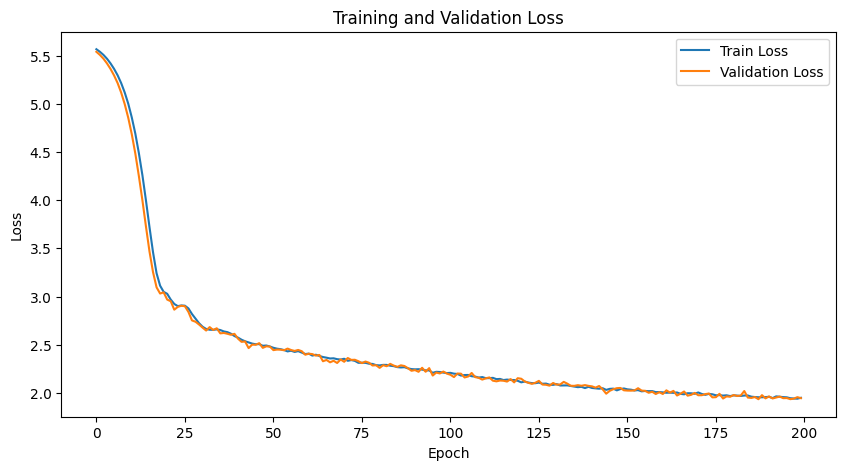

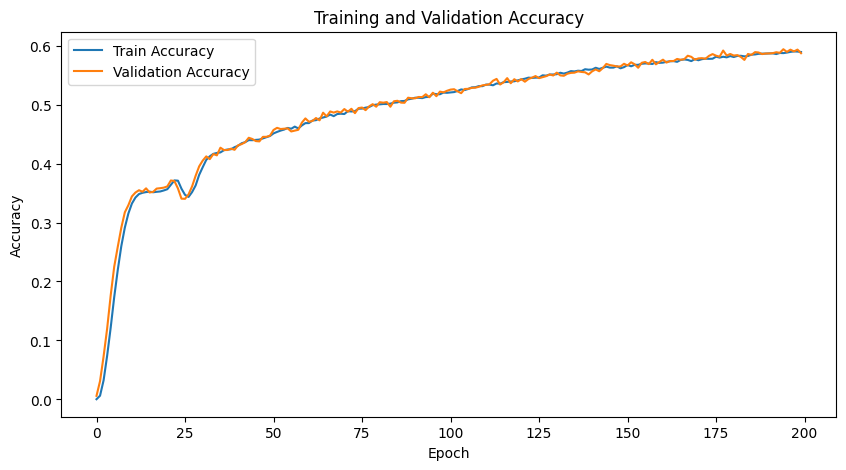

In [ ]:


# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:

if running_local:
    PATH = "model/model.pth"
else:
    PATH = "drive/MyDrive/StructuralBioinformatics/model/model.pth"

In [ ]:
torch.save(model, PATH)

In [ ]:
# Load Model For Inference

model = torch.load(PATH)
model.eval()

ContactNet(
  (layers): ModuleList(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=128, out_features=6, bias=True)
  )
)

In [ ]:
# Convert your test dataset into PyTorch tensors
X_test_torch = torch.tensor(X_test.values).float()
y_test_torch = torch.tensor(y_test.values).long()

# Create a DataLoader for your test set
test_dataset = TensorDataset(X_test_torch, y_test_torch)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        # Forward pass
        outputs = model(inputs)

        # Get predicted class indices
        _, preds = torch.max(outputs, 1)

        y_pred.extend(preds.tolist())
        y_true.extend(labels.tolist())

y_pred_oneHot = pd.get_dummies(y_pred, columns=5).values
print(classification_report(y_true, y_pred_oneHot, target_names = cat_names))

              precision    recall  f1-score   support

       HBOND       0.80      0.60      0.69     29764
       IONIC       0.23      0.90      0.36       800
    PICATION       0.05      0.96      0.09        55
   PIPISTACK       0.22      1.00      0.35       922
      SSBOND       0.22      1.00      0.37        78
         VDW       0.42      0.44      0.43     13801

   micro avg       0.57      0.57      0.57     45420
   macro avg       0.32      0.82      0.38     45420
weighted avg       0.67      0.57      0.60     45420
 samples avg       0.57      0.57      0.57     45420



In [ ]:
accuracy_score(y_true, y_pred_oneHot)

0.5668428005284016

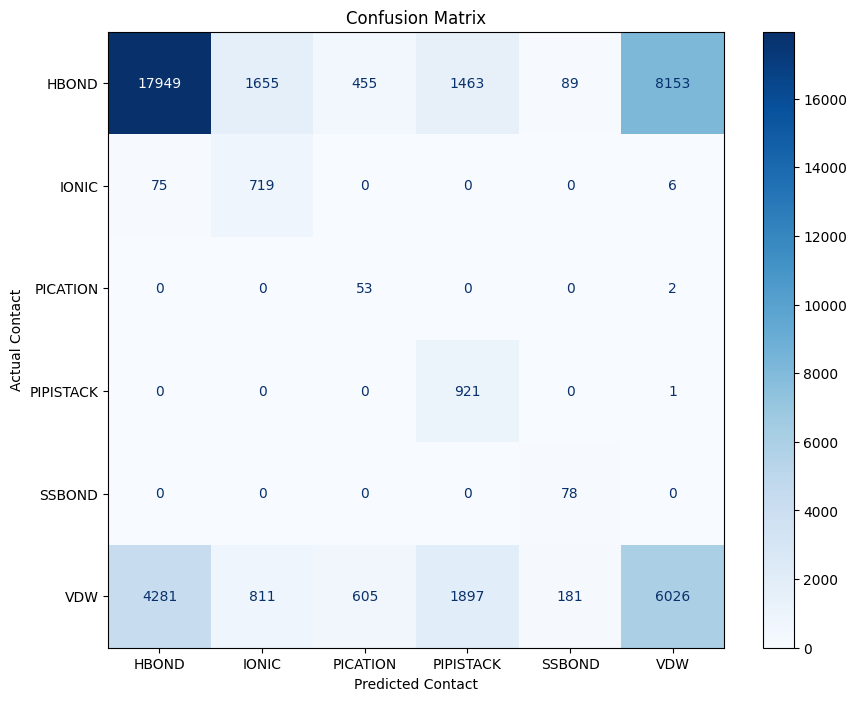

In [ ]:
cm = confusion_matrix(np.argmax(y_true,axis=1), y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(10, 8))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cat_names)
cm_display.plot(cmap='Blues', ax=ax)

plt.title('Confusion Matrix')
plt.ylabel('Actual Contact')
plt.xlabel('Predicted Contact')
plt.show()